In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
from tqdm import tqdm

In [ ]:
# Data information:
# - input_noisy: Input data with 5% noise added
# - input: Input data without noise
# - The dataset contains patches of 9x9 voxels, with 8 different inversion times (P=8)
# - The goal is to reconstruct spectra for 32 different T1 times (Q=32)

In [3]:
data = mat73.loadmat('../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
data.keys()

dict_keys(['input', 'input_noisy', 'ref'])

In [4]:
input_noisy = data['input_noisy']
input_clean = data['input']
ref = data['ref']

In [5]:
print("Shape of input data:", input_clean.shape)
print("Shape of noisy input data:", input_noisy.shape)
print("Shape of reference data:", ref.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of noisy input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [6]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

Plotting signals for sample 130 (completely valid in both noisy input and reference data).


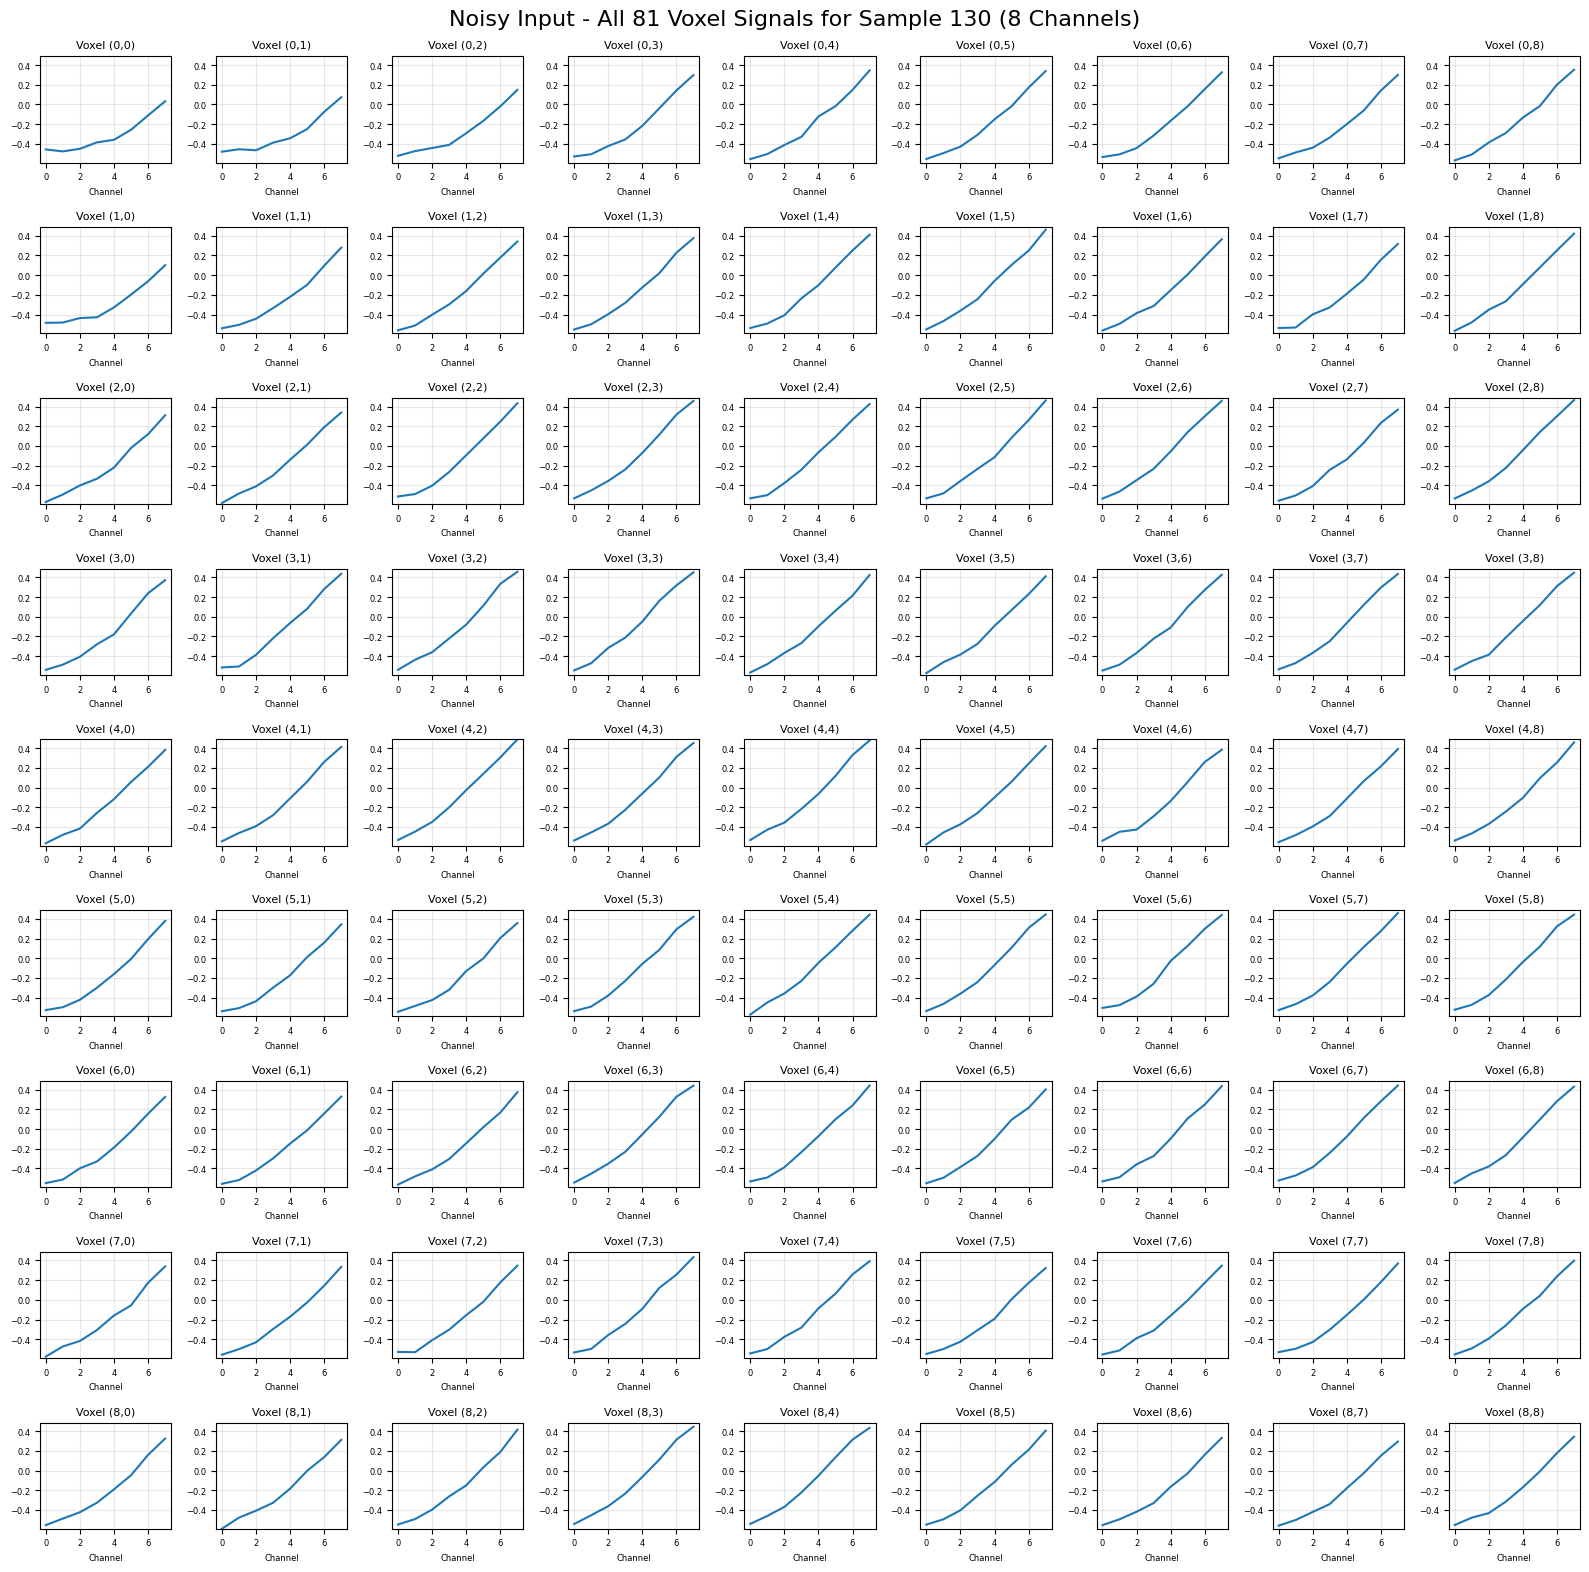

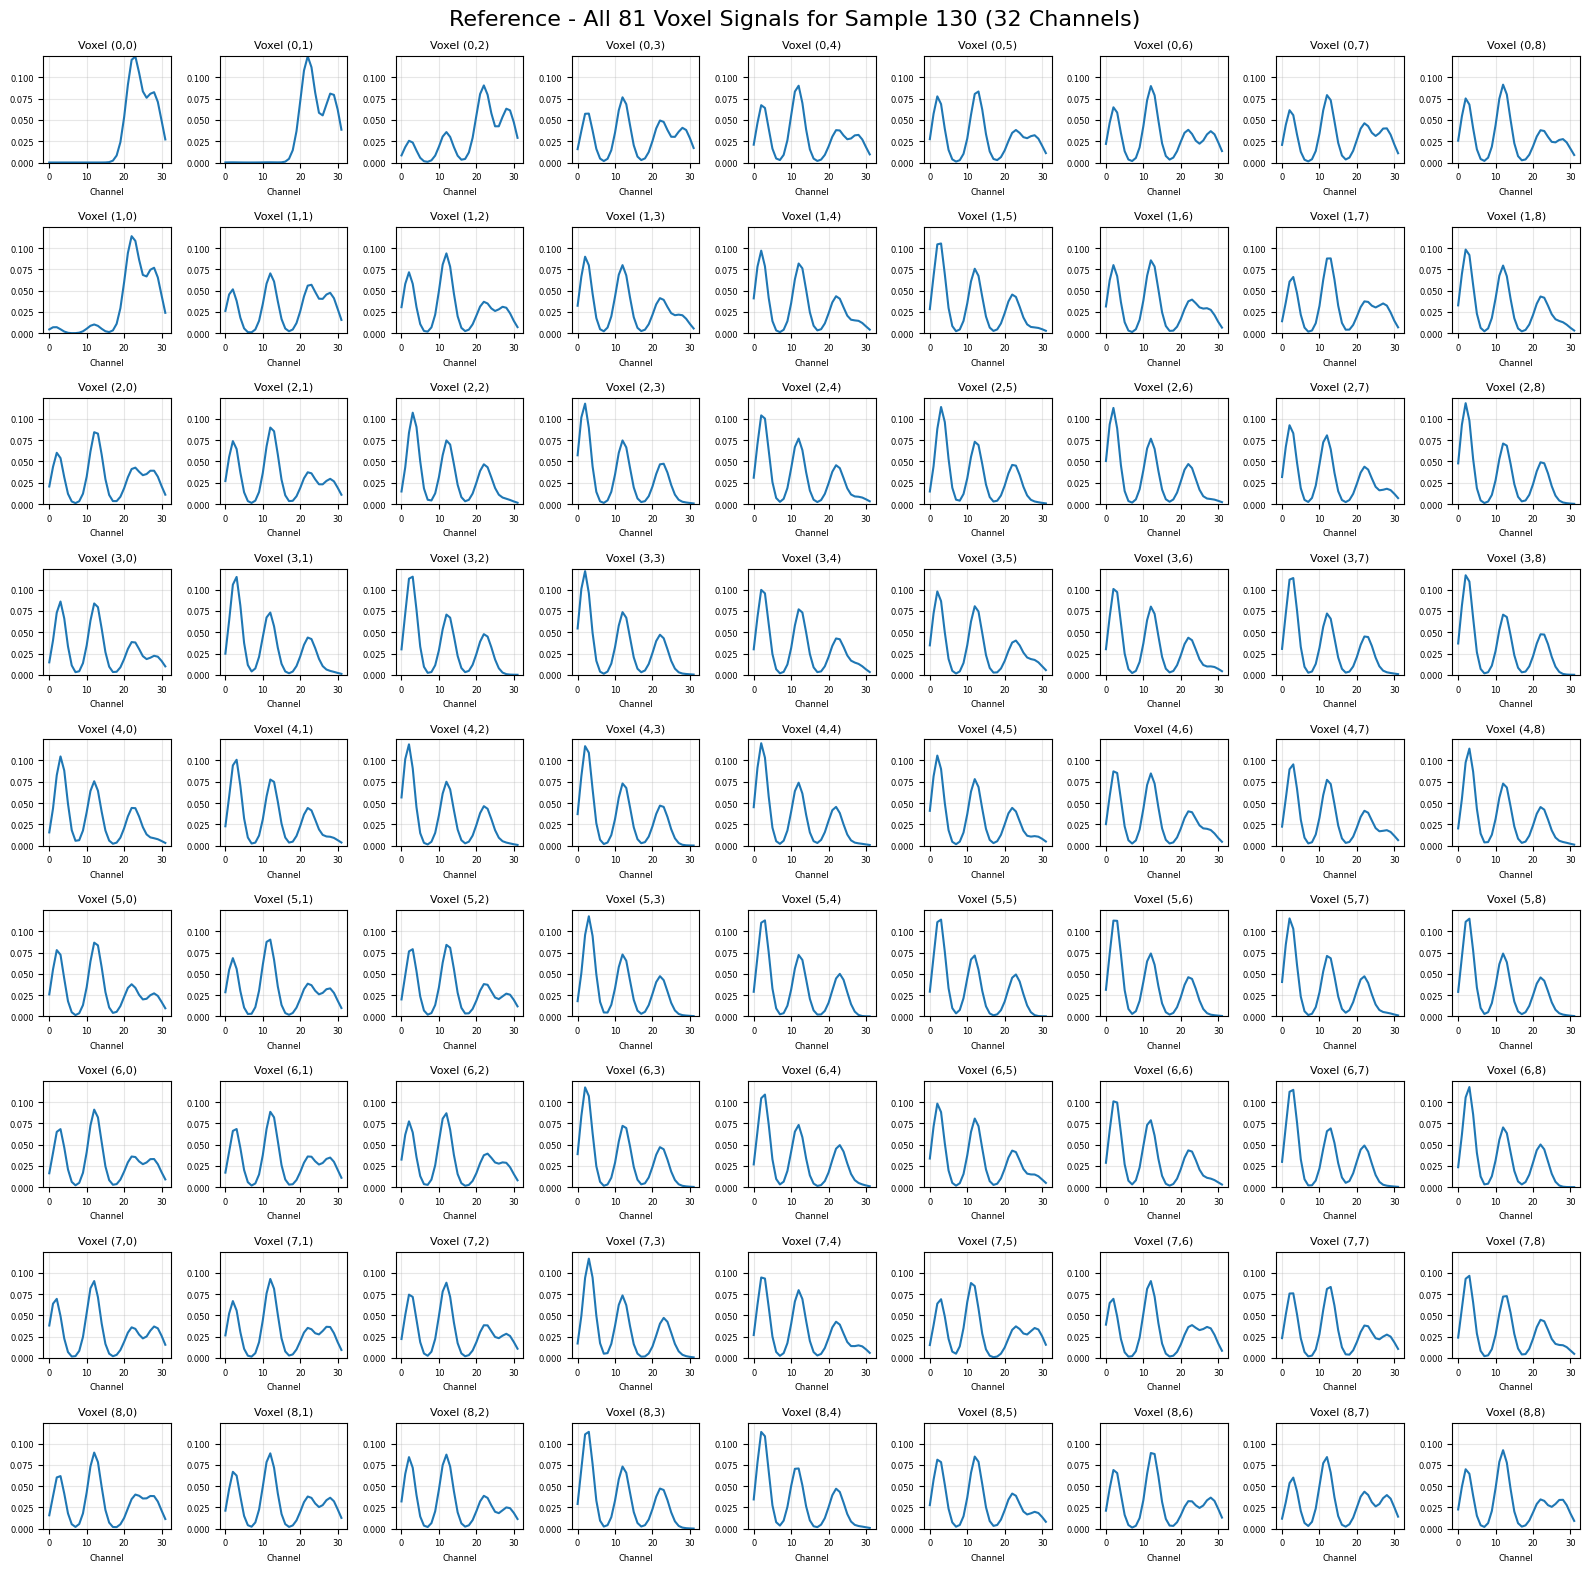

In [ ]:
# Initial Data Visualization
valid_samples_noisy = np.where(np.sum(np.isnan(input_noisy), axis=(0, 1, 2)) == 0)[0]
valid_samples_ref = np.where(np.sum(np.isnan(ref), axis=(0, 1, 2)) == 0)[0]
common_valid_samples = np.intersect1d(valid_samples_noisy, valid_samples_ref)

if len(common_valid_samples) > 0:
    sample_to_plot = common_valid_samples[0]
    print(f"Plotting signals for sample {sample_to_plot} (completely valid in both noisy input and reference data).")
elif len(valid_samples_noisy) > 0:
    sample_to_plot = valid_samples_noisy[0]
    print(f"No common valid samples. Plotting based on noisy input validity: sample {sample_to_plot}.")
elif len(valid_samples_ref) > 0:
    sample_to_plot = valid_samples_ref[0]
    print(f"No common valid samples, no valid noisy samples. Plotting based on ref validity: sample {sample_to_plot}.")
else:
    sample_to_plot = 0
    print(f"No completely valid samples found in either dataset. Plotting signals for sample {sample_to_plot} (using NaN masking).")


def plot_voxel_signals(data, sample_idx, title_prefix=""):
    """Plots all signals for a given 9x9 patch (sample)."""
    n_voxels = data.shape[0] * data.shape[1]  # 9x9 = 81
    n_channels = data.shape[2]

    fig, axes = plt.subplots(9, 9, figsize=(16, 16))
    axes = axes.flatten()

    for i in range(n_voxels):
        row = i // 9
        col = i % 9
        voxel_data = data[row, col, :, sample_idx]

        masked_voxel_data = np.ma.masked_array(voxel_data, mask=np.isnan(voxel_data))

        axes[i].plot(masked_voxel_data)
        axes[i].set_title(f'Voxel ({row},{col})', fontsize=8)
        axes[i].tick_params(axis='both', which='major', labelsize=6)
        axes[i].set_ylim(np.nanmin(data[:, :, :, sample_idx]),
                         np.nanmax(data[:, :, :, sample_idx]))
        axes[i].set_xlabel("Channel", fontsize=6)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle(
        f'{title_prefix} - All {n_voxels} Voxel Signals for Sample {sample_idx} ({n_channels} Channels)',
        fontsize=16)
    plt.show()

plot_voxel_signals(input_noisy, sample_to_plot, title_prefix="Noisy Input")
plot_voxel_signals(ref, sample_to_plot, title_prefix="Reference")

In [ ]:
# Data Quality Analysis
def analyze_data_quality(data, name):
    """Analyze data quality including NaN checks"""
    total_elements = np.prod(data.shape)
    nan_count = np.isnan(data).sum()
    nan_percentage = (nan_count / total_elements) * 100
    
    valid_min = np.nanmin(data)
    valid_max = np.nanmax(data)
    
    print(f"\n{name} Data Quality:")
    print(f"Shape: {data.shape}")
    print(f"NaN count: {nan_count:,} ({nan_percentage:.2f}%)")
    print(f"Value range (excluding NaN): [{valid_min:.3f}, {valid_max:.3f}]")
    
    return {
        'nan_count': nan_count,
        'valid_min': valid_min,
        'valid_max': valid_max
    }

clean_stats = analyze_data_quality(input_clean, "Clean Input")
noisy_stats = analyze_data_quality(input_noisy, "Noisy Input")
ref_stats = analyze_data_quality(ref, "Reference")


Clean Input Data Quality:
Shape: (9, 9, 8, 47932)
NaN count: 1,635,840 (5.27%)
Value range (excluding NaN): [-0.648, 0.613]

Noisy Input Data Quality:
Shape: (9, 9, 8, 47932)
NaN count: 1,635,840 (5.27%)
Value range (excluding NaN): [-0.667, 0.634]

Reference Data Quality:
Shape: (9, 9, 32, 47932)
NaN count: 0 (0.00%)
Value range (excluding NaN): [-0.010, 1.000]


In [ ]:
# NaN Analysis
def check_nan_consistency(input_clean, input_noisy):
    """Check if NaN values are consistent between clean and noisy datasets"""
    nan_mismatch = np.sum(np.isnan(input_clean) != np.isnan(input_noisy))
    print(f"NaN mismatches between clean and noisy: {nan_mismatch}")

check_nan_consistency(input_clean, input_noisy)

NaN mismatches between clean and noisy: 0


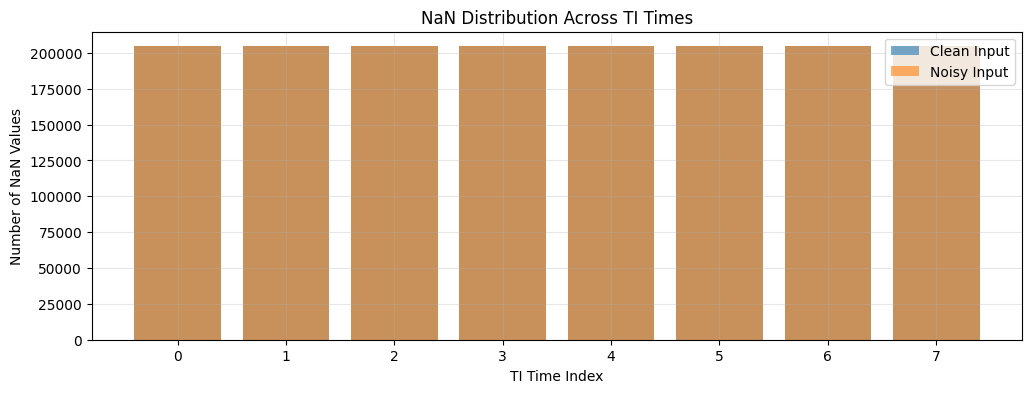

In [ ]:
nan_per_channel_clean = np.isnan(input_clean).sum(axis=(0, 1, 3))
nan_per_channel_noisy = np.isnan(input_noisy).sum(axis=(0, 1, 3))

plt.figure(figsize=(12, 4))
plt.bar(range(len(nan_per_channel_clean)), nan_per_channel_clean, alpha=0.6, label='Clean Input')
plt.bar(range(len(nan_per_channel_noisy)), nan_per_channel_noisy, alpha=0.6, label='Noisy Input')
plt.title('NaN Distribution Across TI Times')
plt.xlabel('TI Time Index')
plt.ylabel('Number of NaN Values')
plt.legend()
plt.show()

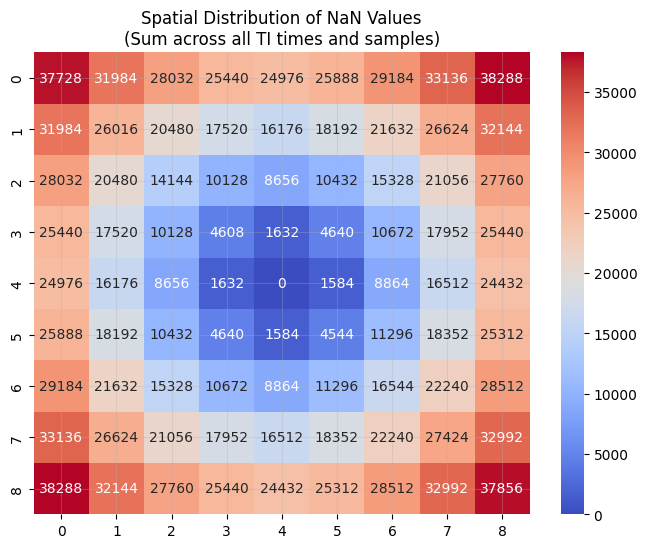

In [11]:
nan_spatial_clean = np.isnan(input_clean).sum(axis=(2, 3))

plt.figure(figsize=(8, 6))
sns.heatmap(nan_spatial_clean, annot=True, fmt='g', cmap='coolwarm')
plt.title('Spatial Distribution of NaN Values\n(Sum across all TI times and samples)')
plt.show()

In [12]:
samples_with_nan = np.any(np.isnan(input_clean), axis=(0, 1, 2))
nan_sample_count = np.sum(samples_with_nan)

print(f"Samples with at least one NaN: {nan_sample_count:,} out of {len(samples_with_nan):,}")
print(f"Percentage of samples with NaN: {(nan_sample_count / len(samples_with_nan)) * 100:.2f}%")

Samples with at least one NaN: 13,360 out of 47,932
Percentage of samples with NaN: 27.87%


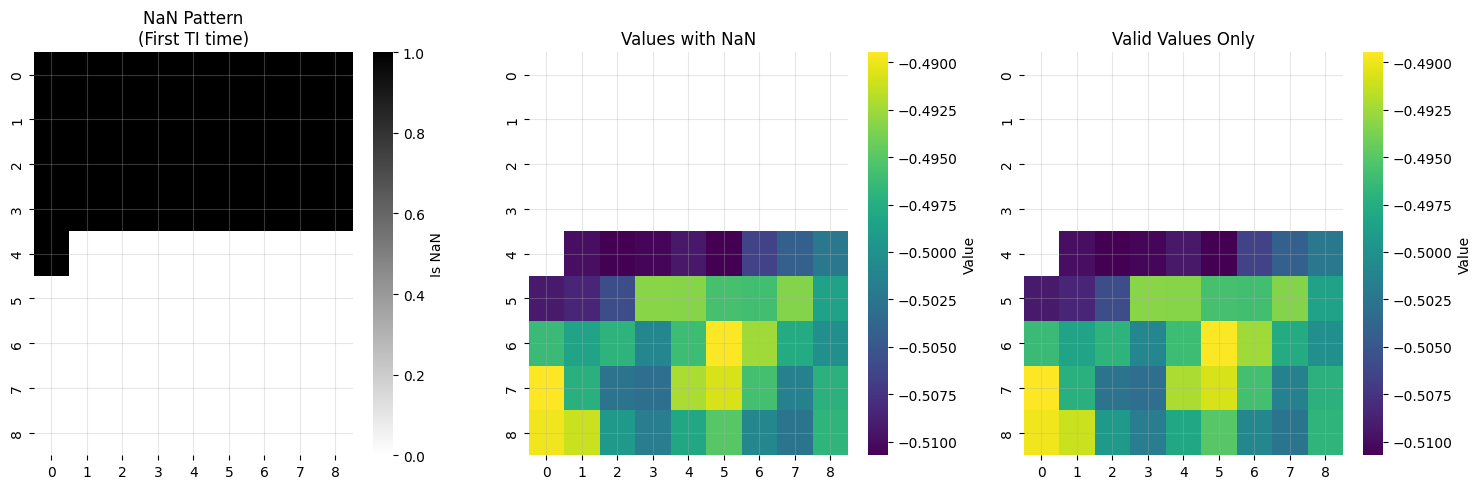

In [ ]:
if np.sum(samples_with_nan) > 0:
    nan_sample_idx = np.where(samples_with_nan)[0][0]

    plt.figure(figsize=(15, 5))

    # NaN pattern
    plt.subplot(131)
    sns.heatmap(np.isnan(input_clean[:, :, 0, nan_sample_idx]), cmap='binary', cbar_kws={'label': 'Is NaN'})
    plt.title('NaN Pattern\n(First TI time)')

    # Values including NaNs
    plt.subplot(132)
    sns.heatmap(input_clean[:, :, 0, nan_sample_idx], cmap='viridis', cbar_kws={'label': 'Value'})
    plt.title('Values with NaN')

    # Only valid values
    plt.subplot(133)
    valid_data = np.ma.masked_array(
        input_clean[:, :, 0, nan_sample_idx],
        mask=np.isnan(input_clean[:, :, 0, nan_sample_idx]))
    sns.heatmap(valid_data, cmap='viridis', cbar_kws={'label': 'Value'})
    plt.title('Valid Values Only')

    plt.tight_layout()
    plt.show()
else:
    print("No samples with NaN values found.")

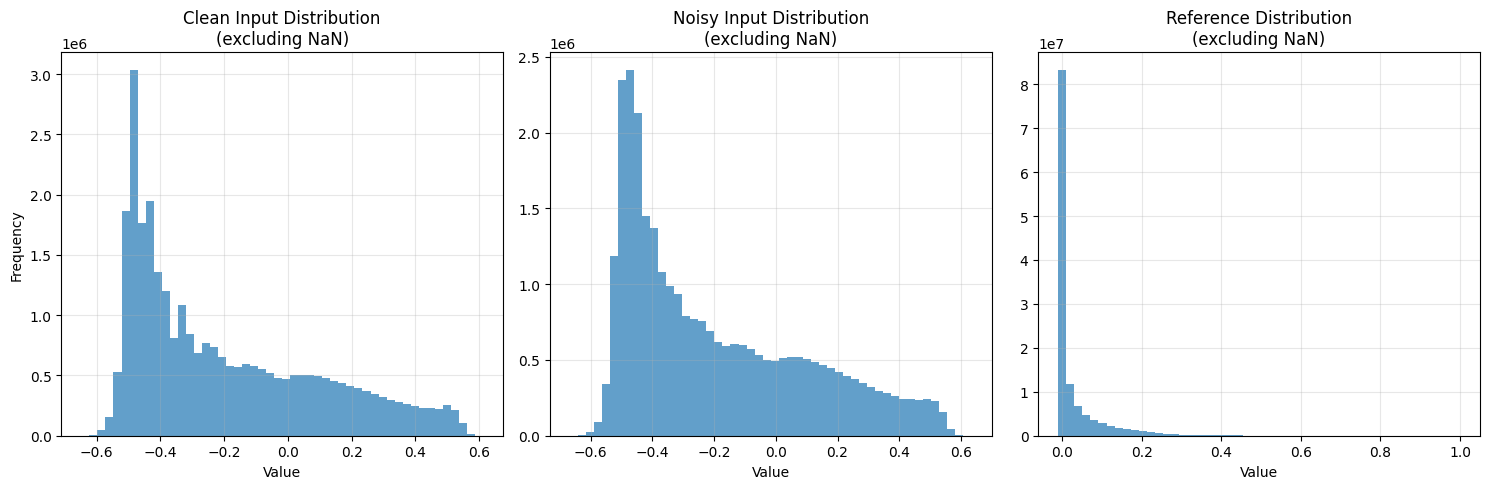

In [ ]:
# Data Distribution
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(input_clean[~np.isnan(input_clean)].ravel(), bins=50, alpha=0.7)
plt.title('Clean Input Distribution\n(excluding NaN)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(input_noisy[~np.isnan(input_noisy)].ravel(), bins=50, alpha=0.7)
plt.title('Noisy Input Distribution\n(excluding NaN)')
plt.xlabel('Value')

plt.subplot(133)
plt.hist(ref[~np.isnan(ref)].ravel(), bins=50, alpha=0.7)
plt.title('Reference Distribution\n(excluding NaN)')
plt.xlabel('Value')

plt.tight_layout()
plt.show()


Noise statistics (excluding NaN):
Mean std: 0.01563
Min std: 0.00929
Max std: 0.01949


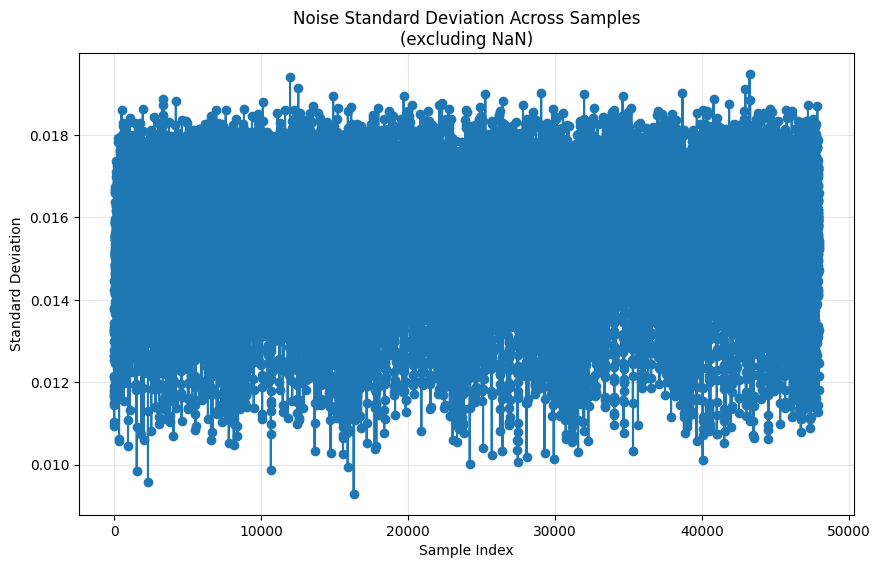

In [ ]:
# Noise Analysis
def analyze_noise(clean, noisy):
    """Analyze noise patterns handling NaN values"""
    valid_mask = ~np.isnan(clean) & ~np.isnan(noisy)
    
    noise_difference = np.zeros_like(clean)
    noise_difference[valid_mask] = noisy[valid_mask] - clean[valid_mask]
    
    noise_std = np.nanstd(noise_difference, axis=(0,1,2))
    
    plt.figure()
    valid_std = noise_std[~np.isnan(noise_std)]
    plt.plot(range(len(valid_std)), valid_std, 'o-')
    plt.title('Noise Standard Deviation Across Samples\n(excluding NaN)')
    plt.xlabel('Sample Index')
    plt.ylabel('Standard Deviation')
    
    print("\nNoise statistics (excluding NaN):")
    print(f"Mean std: {np.nanmean(noise_std):.5f}")
    print(f"Min std: {np.nanmin(noise_std):.5f}")
    print(f"Max std: {np.nanmax(noise_std):.5f}")
    
    return noise_std

noise_std = analyze_noise(input_clean, input_noisy)


Plotting spatial patterns for sample 130


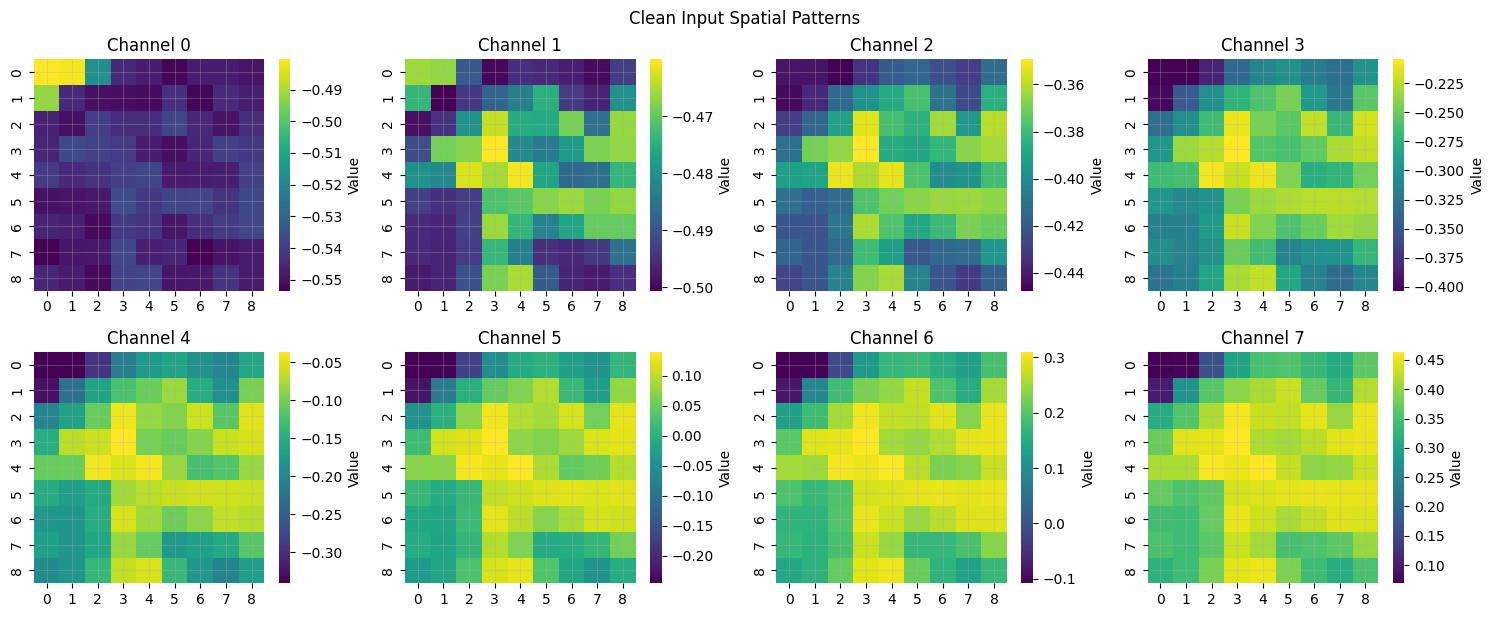

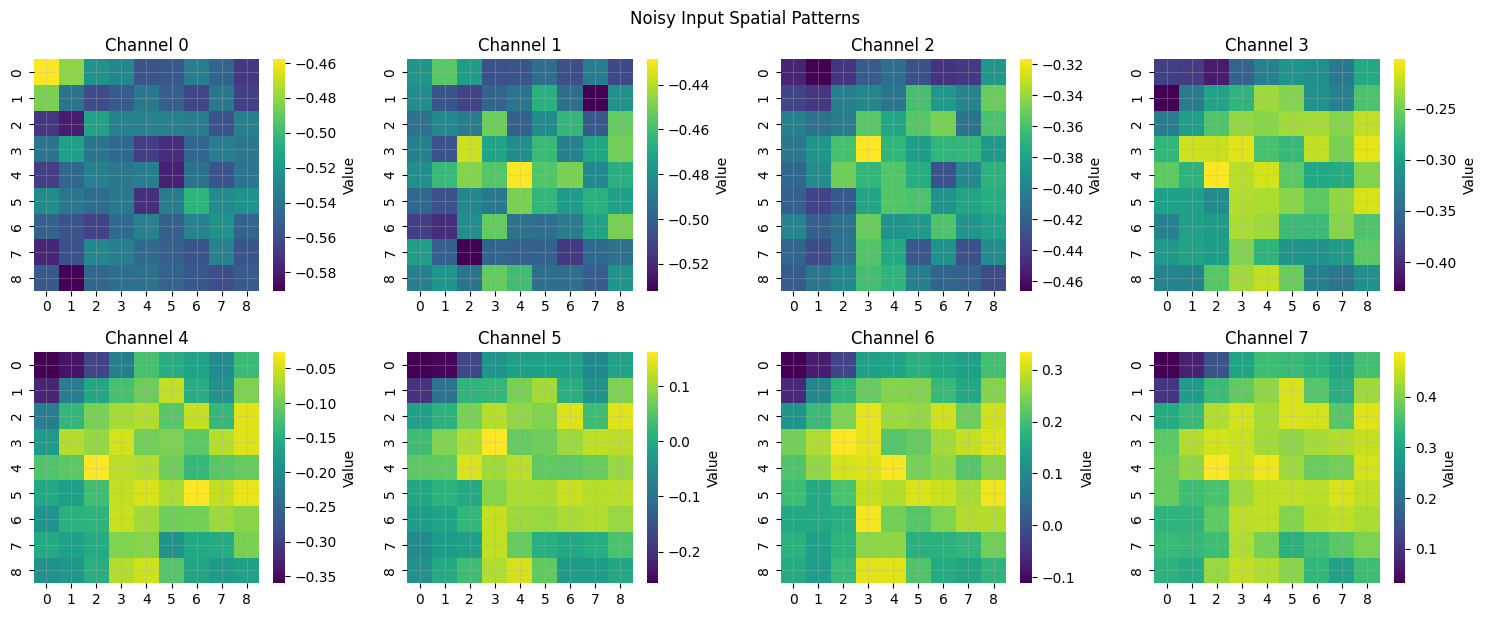

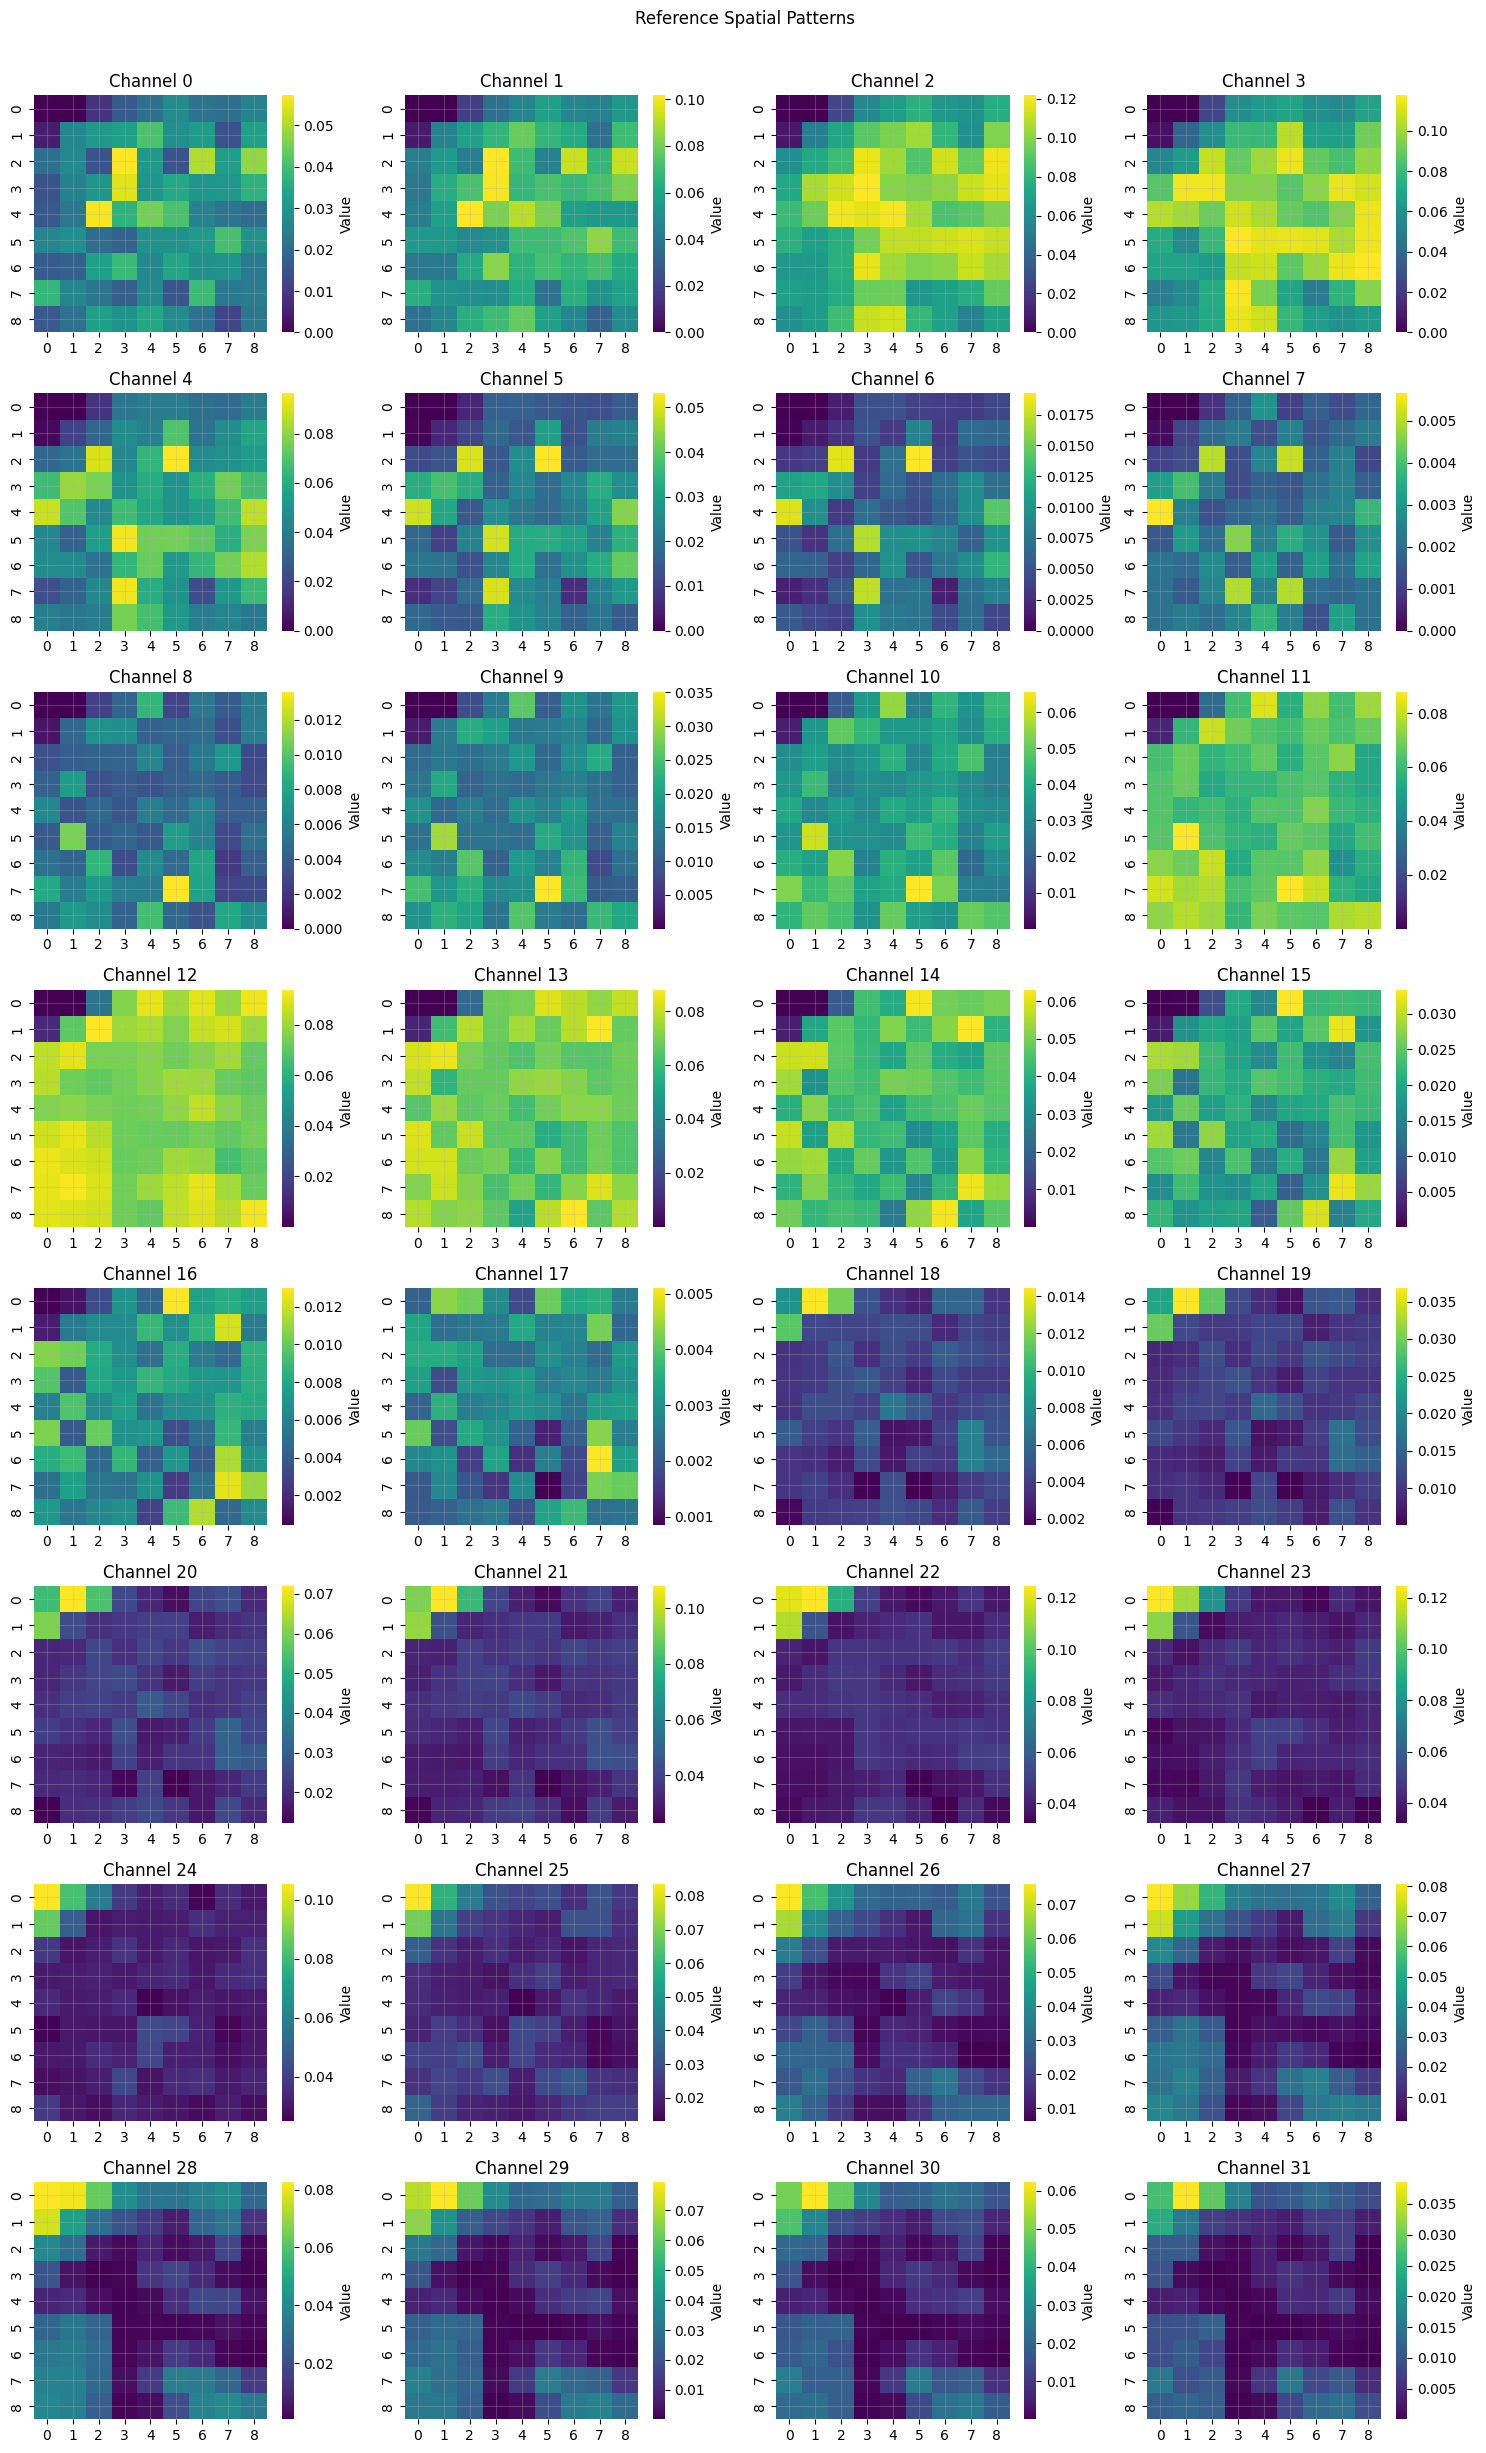

In [ ]:
# Spatial Pattern
def plot_spatial_patterns(data, sample_idx, title):
    """Plot spatial patterns handling NaN values."""
    n_channels = data.shape[2]
    rows = (n_channels + 3) // 4
    plt.figure(figsize=(15, 3 * rows))

    for i in range(n_channels):
        plt.subplot(rows, 4, i + 1)
        pattern = data[:, :, i, sample_idx]
        mask = np.isnan(pattern)

        sns.heatmap(np.ma.array(pattern, mask=mask), cmap='viridis', cbar_kws={'label': 'Value'})
        plt.title(f'Channel {i}')

    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

valid_samples = np.where(np.sum(np.isnan(input_clean), axis=(0, 1, 2)) == 0)[0]
if len(valid_samples) > 0:
    sample_idx = valid_samples[0]
    print(f"\nPlotting spatial patterns for sample {sample_idx}")
    plot_spatial_patterns(input_clean, sample_idx, 'Clean Input Spatial Patterns')
    plot_spatial_patterns(input_noisy, sample_idx, 'Noisy Input Spatial Patterns')
    plot_spatial_patterns(ref, sample_idx, 'Reference Spatial Patterns')
else:
    print("\nNo completely valid samples found. Choosing first sample:")
    plot_spatial_patterns(input_clean, 0, 'Clean Input Spatial Patterns')
    plt.show()


Valid Data Summary:
Input Clean: 94.7% valid (avg)
Input Noisy: 94.7% valid (avg)
Reference: 100.0% valid (avg)


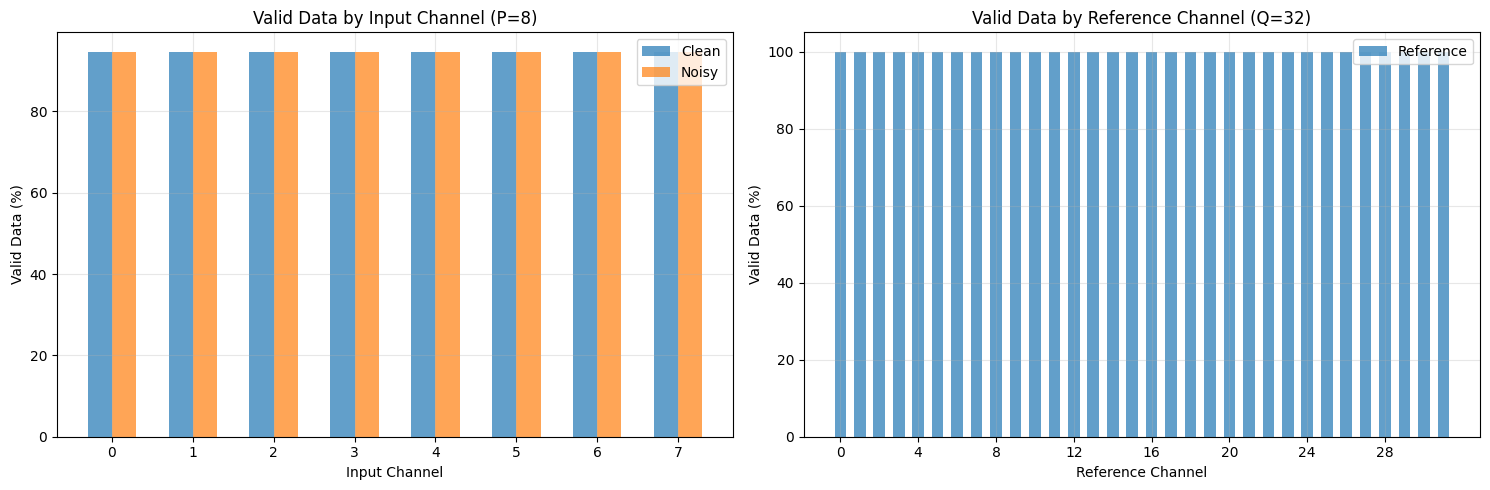

In [ ]:
# Valid Data
def compute_valid_data_percentage():
    """Compute percentage of valid data across different dimensions"""
    valid_clean = ~np.isnan(input_clean)
    valid_noisy = ~np.isnan(input_noisy)
    valid_ref = ~np.isnan(ref)
    
    valid_by_channel_clean = np.mean(valid_clean, axis=(0,1,3)) * 100
    valid_by_channel_noisy = np.mean(valid_noisy, axis=(0,1,3)) * 100
    valid_by_channel_ref = np.mean(valid_ref, axis=(0,1,3)) * 100
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    x_input = np.arange(len(valid_by_channel_clean))
    plt.bar(x_input - 0.15, valid_by_channel_clean, width=0.3, label='Clean', alpha=0.7)
    plt.bar(x_input + 0.15, valid_by_channel_noisy, width=0.3, label='Noisy', alpha=0.7)
    plt.xlabel('Input Channel')
    plt.ylabel('Valid Data (%)')
    plt.title('Valid Data by Input Channel (P=8)')
    plt.legend()
    plt.xticks(x_input)
    
    plt.subplot(122)
    x_ref = np.arange(len(valid_by_channel_ref))
    plt.bar(x_ref, valid_by_channel_ref, width=0.6, label='Reference', alpha=0.7)
    plt.xlabel('Reference Channel')
    plt.ylabel('Valid Data (%)')
    plt.title('Valid Data by Reference Channel (Q=32)')
    plt.legend()
    plt.xticks(x_ref[::4])
    
    plt.tight_layout()
    
    print("\nValid Data Summary:")
    print(f"Input Clean: {np.mean(valid_by_channel_clean):.1f}% valid (avg)")
    print(f"Input Noisy: {np.mean(valid_by_channel_noisy):.1f}% valid (avg)")
    print(f"Reference: {np.mean(valid_by_channel_ref):.1f}% valid (avg)")

compute_valid_data_percentage()